In [1]:
import numpy as np
import pandas as pd

# Loading the data 

In [2]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = train_data.sample(frac=0.2)#pd.read_csv('dataset/test.csv')

In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#checking if there are any nan value in the data frame
print(train_data.isna().any().any(),test_data.isna().any().any())

False False


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

In [6]:
x = train_data.drop(['label'],axis=1)
x = torch.tensor(np.array(x))
x = x.reshape(-1,28,28).unsqueeze(1)
x.shape

torch.Size([42000, 1, 28, 28])

In [7]:
targets = np.array(train_data['label'])
data = np.array(train_data.drop(['label'],axis=1))
        
targets = torch.tensor(targets).long()
data = torch.tensor(data).to(torch.float64).reshape(-1,28,28).unsqueeze(1)
        

In [8]:
targets[0], data[0].shape

(tensor(1), torch.Size([1, 28, 28]))

In [9]:
y = x[0]
y.shape

torch.Size([1, 28, 28])

In [10]:
import matplotlib.pyplot as plt
def show_img(x,label=-1):
    if len(x.shape) > 2:
        x = x.squeeze(0).squeeze(0)
    plt.imshow(x,cmap='gray')
    plt.axis('off')
    if label != -1 : plt.title(label)
    plt.show()

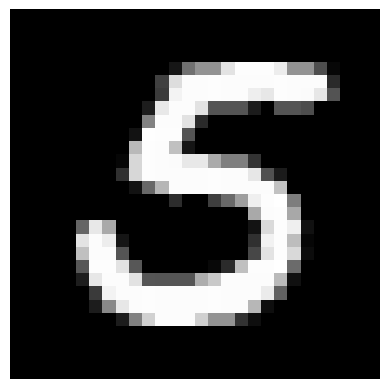

In [11]:
x[0].shape
show_img(x[900])

# Creating custom dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self,train_dataframe):

        self.targets = np.array(train_dataframe['label'])
        self.data = np.array(train_dataframe.drop(['label'],axis=1))
            
        self.targets = torch.tensor(self.targets).long()
        self.data = torch.tensor(self.data).float().reshape(-1,28,28).unsqueeze(1)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get data sample and corresponding target
        sample = self.data[idx]
        target = self.targets[idx]
        return sample, target


In [13]:
test_custom_dataset = CustomDataset(test_data)
test_loader = DataLoader(test_custom_dataset, batch_size=4, pin_memory=True)#, shuffle=shuffle, num_workers=num_workers)

In [14]:
custom_dataset = CustomDataset(train_data)
batch_size = 4
# shuffle = False  # Set to True if you want to shuffle your data
# num_workers = 1  # Number of subprocesses to use for data loading

custom_dataloader = DataLoader(custom_dataset, batch_size=batch_size, pin_memory=True)#, shuffle=shuffle, num_workers=num_workers)

In [15]:
for batch_data, batch_targets in custom_dataloader:
    print("Batch data type:", type(batch_data))
    print("Batch target type:", type(batch_targets))
    print("Batch data shape:", batch_data.shape)
    print("Batch target shape:", batch_targets.shape)
    print("Batch data shape:", batch_data.dtype)
    break  

Batch data type: <class 'torch.Tensor'>
Batch target type: <class 'torch.Tensor'>
Batch data shape: torch.Size([4, 1, 28, 28])
Batch target shape: torch.Size([4])
Batch data shape: torch.float32


# Creating a model

In [16]:
import torch.nn as nn

In [17]:
class mnist_model(nn.Module):
    def __init__(self):
        super(mnist_model,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=2,kernel_size=3,stride=1)
        self.batch_norm1 = nn.BatchNorm2d(2)
        self.conv2 = nn.Conv2d(in_channels=2,out_channels=4,kernel_size=3,stride=1)
        self.batch_norm2 = nn.BatchNorm2d(4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.in_value = 4*5*5
        self.lin = nn.Linear(self.in_value,10)
        self.relu = nn.ReLU(inplace=True)
        self.soft_max = nn.Softmax(dim=1)

    def forward(self,x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batch_norm1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batch_norm2(x)
        x = self.pool(x)

        x = x.view(-1,self.in_value)
        x = self.lin(x)

        return self.soft_max(x)


    pass

x = torch.rand(1,1,28,28)
model = mnist_model()
y = model(x)
y

tensor([[0.1176, 0.0579, 0.0882, 0.0832, 0.0367, 0.1676, 0.1248, 0.2542, 0.0504,
         0.0193]], grad_fn=<SoftmaxBackward0>)

# Training the model

In [18]:
from tqdm import tqdm
from torch.optim import Adam

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else: device = torch.device('cpu')
device

device(type='cuda')

In [20]:
epoches = 200

model = mnist_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in tqdm(range(epoches)):
    model.train()

    running_loss = 0.0
    for data, target in custom_dataloader:
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


100%|██████████| 200/200 [1:15:48<00:00, 22.74s/it]


Accuracy on the test set: 97.56%


In [21]:
pre_datafame = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
pre_datafame.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X = torch.tensor(np.array(pre_datafame)).float().reshape(-1,28,28).unsqueeze(1)

In [23]:
X.shape

torch.Size([28000, 1, 28, 28])

## submission

In [24]:
i = 10289
y = model(X.to(device))
_, predicted = torch.max(y.data, 1)
# show_img(X[i],label=predicted)

In [25]:
# _, predicted = torch.max(y.data, 1)
predicted = predicted.to('cpu').numpy()
predicted

array([2, 0, 9, ..., 3, 9, 2])

In [26]:
len(predicted)

28000

In [27]:
pre = predicted.astype(int)
df = pd.DataFrame(pre,columns=['Label'])
df.head()

,Label
0,2
1,0
2,9
3,9
4,3


In [28]:
df.to_csv('prediction.csv',index_label='ImageId', index=True)